# Performance Notebook
### raw data(no feature eng.)
`Hold-out accuracy : 0.8132969034608379`

`Balanced accuracy : 0.7661820286193357`

`5-fold CV accuracy : 0.815 ± 0.005`

`5-fold CV F1-macro : 0.803 ± 0.011`

In [1]:
# traffic_sign_random_forest.py
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, balanced_accuracy_score,
                             classification_report, f1_score,
                             roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

SEARCH_FOR_HYOPERPARAMS = False

# ------------------------------------------------------------------
# 1.  Load metadata (image_id + class label) and all feature tables
# ------------------------------------------------------------------

BASE_PATH = '../2025_A2/train'
METADATA_PATH = BASE_PATH + '/train_metadata.csv'
train_meta = pd.read_csv(METADATA_PATH)   # columns: image_id, ClassId
FEATURE_PATH = BASE_PATH + '/Features'

print(FEATURE_PATH + "/additional_features.csv")
add_feats  = pd.read_csv(FEATURE_PATH + "/additional_features.csv")  # edge_density, mean_b/g/r …
color_hist = pd.read_csv(FEATURE_PATH + "/color_histogram.csv")      # 95 colour-histogram bins
hog_pca    = pd.read_csv(FEATURE_PATH + "/hog_pca.csv")              # 19 PCA-compressed HOG dims

../2025_A2/train/Features/additional_features.csv


# Data Pre-Processing 

### Feature Weight Calculation

In [12]:
import pandas as pd
from typing import Dict

def make_class_weights(labels: pd.Series) -> Dict[int, float]:
    """
    Compute inverse-frequency class weights from a pandas Series of class labels.
    
    Parameters
    ----------
    labels : pd.Series
        One-dimensional Series containing the class IDs for every sample.
    
    Returns
    -------
    Dict[int, float]
        Mapping {class_id: weight}.
    """
    counts      = labels.value_counts()          # class → #samples
    n_samples   = len(labels)
    n_classes   = len(counts)
    weights     = n_samples / (n_classes * counts)
    return weights.to_dict()

### Outlier removal

In [4]:
def remove_outliers_iqr(df: pd.DataFrame,
                        k: float = 1.5,
                        cols: Union[None, list[str]] = None,
                        inplace: bool = False) -> pd.DataFrame:
    """
    Drop rows that contain outliers (by the IQR rule) in *every* specified column.

    Parameters
    ----------
    df : pd.DataFrame
        The input data.
    k : float, default 1.5
        Fence width multiplier. 1.5 = Tukey, 3.0 = 'extreme' fences.
    cols : list[str] | None
        Columns to check. If None, all numeric columns are used.
    inplace : bool, default False
        If True, drop rows in the original df and return it.

    Returns
    -------
    pd.DataFrame
        A copy of df with outlier rows removed (unless *inplace* is True).
    """
    if cols is None:
        cols = df.select_dtypes(include='number').columns.tolist()
    if not cols:
        raise ValueError("No numeric columns to evaluate.")

    # Boolean mask that will be True for rows we keep
    mask = pd.Series(True, index=df.index)

    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask &= df[col].between(lower, upper)

    if inplace:
        df.drop(index=df.index[~mask], inplace=True)
        return df
    else:
        return df.loc[mask].copy()

# Build Training & Testing Data

In [10]:
# ------------------------------------------------------------------
# 2.  Merge everything on the common key (image_path)
# ------------------------------------------------------------------
def merge(meta):
    return (meta
            .merge(add_feats,  on="image_path")
            .merge(color_hist, on="image_path")
            .merge(hog_pca,    on="image_path"))

train_df = merge(train_meta)
# test_df  = merge(test_meta)

X = train_df.drop(columns=["ClassId", "image_path"])
y = train_df["ClassId"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape: ", X_train.shape, ", y_train.shape: ", y_train.shape)
print("X_test.shape:  ", X_test.shape, ", y_test.shape:  ", y_test.shape)

print(type(y_train))


X_train.shape:  (4390, 121) , y_train.shape:  (4390,)
X_test.shape:   (1098, 121) , y_test.shape:   (1098,)
<class 'pandas.core.series.Series'>


# Build pipeline

In [ ]:
pipeline = None

if SEARCH_FOR_HYOPERPARAMS:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
                n_estimators=500,
                max_depth=None,
                n_jobs=-1,
                random_state=42))
    ])
    # search for hyper-parameters
    param_grid = {
        "rf__n_estimators": [300, 500, 800],
        "rf__max_depth"   : [None, 20, 40],
        "rf__max_features": ["sqrt", "log2"]
    }
    pipeline = GridSearchCV(pipe,
                        param_grid,
                        cv=5,
                        n_jobs=-1,
                        scoring="accuracy",
                        verbose=1)
    pipeline.fit(X_train, y_train)
    print("Best CV accuracy :", pipeline.best_score_)
    print("Best parameters  :", pipeline.best_params_)
else:
    # predefined hyper-parameters
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
                n_estimators=500,        # from grid-search
                max_depth=None,          # "
                max_features="sqrt",     # "
                n_jobs=-1,
                random_state=42,
                # # vanilla model class weight distribution
                # class_weight="balanced"
                class_weight=make_class_weights(y_train)
        ))
    ])


# Train model

In [ ]:
model = None
if SEARCH_FOR_HYOPERPARAMS:
    model = pipeline.best_estimator_
else:
    model = pipeline

model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight={0: 5.104651162790698,
                                                      1: 0.40352973618898796,
                                                      2: 0.4019410364402124,
                                                      3: 0.6380813953488372,
                                                      4: 0.45781624778391905,
                                                      5: 0.49083184257602863,
                                                      6: 2.126937984496124,
                                                      7: 0.6380813953488372,
                                                      8: 0.6076965669988926,
                                                      9: 0.6187455954897816,
                                                      10: 0.4497490011269337,
                                                      11: 0.6898177247014456,
                                                      12: 0.427...
                                                      16: 2.126937984496124,
                                                      17: 0.8507751937984496,
                                                      18: 0.7853309481216458,
                                                      19: 4.6405919661733614,
                                                      20: 2.4900737379466817,
                                                      21: 2.7592708988057826,
                                                      22: 2.268733850129199,
                                                      23: 1.760224538893344,
                                                      24: 3.2933233308327083,
                                                      25: 0.6150182123844214,
                                                      26: 1.5237764665046858,
                                                      27: 3.6461794019933556,
                                                      28: 1.6736561189477697,
                                                      29: 3.4031007751937983, ...},
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

In [ ]:
import joblib
joblib.dump(model, '../models/random_forest.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../models/random_forest.pkl'

Hold-out accuracy : 0.8132969034608379
Balanced accuracy : 0.7661820286193357

Per-class precision / recall / F1

              precision    recall  f1-score   support

           0      1.000     0.444     0.615         9
           1      0.731     0.845     0.784        58
           2      0.687     0.754     0.719        61
           3      0.703     0.703     0.703        37
           4      0.769     0.741     0.755        54
           5      0.744     0.615     0.674        52
           6      1.000     1.000     1.000        11
           7      0.769     0.714     0.741        42
           8      0.684     0.897     0.776        29
           9      0.814     0.854     0.833        41
          10      0.710     0.815     0.759        54
          11      0.583     0.757     0.659        37
          12      0.982     1.000     0.991        55
          13      1.000     1.000     1.000        60
          14      0.960     1.000     0.980        24
          15      0.9

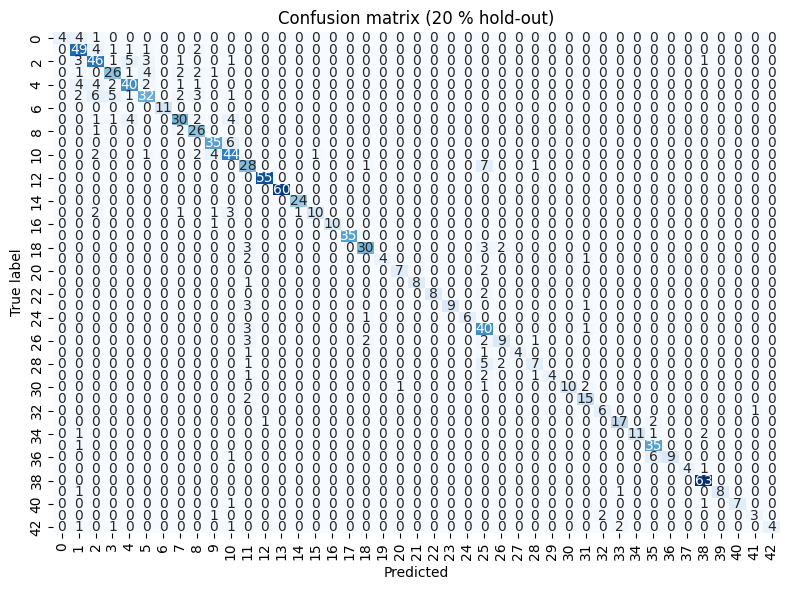

Macro-average ROC-AUC : 0.9924376878631809

5-fold CV accuracy : 0.811 ± 0.008
5-fold CV F1-macro : 0.796 ± 0.018


In [15]:
# ------------------------------------------------------------------
# 5.  Model evaluation
# ------------------------------------------------------------------

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)   # needed for ROC-AUC


# -----------------------------------------------------------
# 1.  Basic metrics on the hold-out set
# -----------------------------------------------------------
print("Hold-out accuracy :", accuracy_score(y_test, y_pred))
print("Balanced accuracy :", balanced_accuracy_score(y_test, y_pred))
print("\nPer-class precision / recall / F1\n")
print(classification_report(y_test, y_pred, digits=3))

# -----------------------------------------------------------
# 2.  Confusion-matrix heat-map
# -----------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True label")
plt.title("Confusion matrix (20 % hold-out)"); plt.tight_layout(); plt.show()
# -----------------------------------------------------------
# 3.  Macro ROC-AUC (one-vs-rest, micro averaged)
# -----------------------------------------------------------
try:
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    print("Macro-average ROC-AUC :", roc_auc)
except Exception as e:
    print("ROC-AUC skipped (classifier lacks predict_proba):", e)

# -----------------------------------------------------------
# 4.  5-fold cross-validation (accuracy & macro-F1)
# -----------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(model, X, y,
                             cv=cv, scoring="accuracy", n_jobs=-1)
f1_scores  = cross_val_score(model, X, y,
                             cv=cv, scoring="f1_macro", n_jobs=-1)

print("\n5-fold CV accuracy : %.3f ± %.3f" % (acc_scores.mean(), acc_scores.std()))
print("5-fold CV F1-macro : %.3f ± %.3f" % (f1_scores.mean(),  f1_scores.std()))

# (Optional) get CV-wide confusion matrix
y_pred_cv = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
cm_cv = confusion_matrix(y, y_pred_cv)
